In [1]:
import sys
import time
from pathlib import Path
import os
import pandas as pd
import numpy as np
import warnings

warnings.simplefilter(action='ignore', category=FutureWarning)

In [2]:
path = Path(os.getcwd())
path = str(path)
print(path)
sys.path.insert(1, path)

/Users/ckingersoll/ROUX/crispr-ga/src


In [3]:
import ga as ga
import eda as eda
import crispr_ga as cga
import gomea as gomea
import utils as utils

### Get knapsack problems
Problems numbers range from 1 - 8

In [4]:
problem_number = 8

capacity, weights, profits, solution = utils.get_problem(problem_number)
n = len(weights)

print("Capacity: ", capacity)
print("Weights: ", weights)
print("Profits: ", profits)
print("Solution: ", solution)
print("Total profit: ", sum(profits[i] for i in range(n) if solution[i] == 1))

Capacity:  6404180
Weights:  [382745, 799601, 909247, 729069, 467902, 44328, 34610, 698150, 823460, 903959, 853665, 551830, 610856, 670702, 488960, 951111, 323046, 446298, 931161, 31385, 496951, 264724, 224916, 169684]
Profits:  [825594, 1677009, 1676628, 1523970, 943972, 97426, 69666, 1296457, 1679693, 1902996, 1844992, 1049289, 1252836, 1319836, 953277, 2067538, 675367, 853655, 1826027, 65731, 901489, 577243, 466257, 369261]
Solution:  [1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1]
Total profit:  13549094


## Run Standard GA, CRISPR GA, EDA and GOMEA on Knapsack problems
Example configurations and convergence plots are provided for each algorithm. Note that the GOMEA is a draft implementation and was not included in the conference paper. However, it will likely be included in future experiments on harder optimizations problems.

### Estimation of Distribution Algorithm
This algorithm samples from a univariate distribution model to generate new solutions. It borrows the steady state genetic algorithm approach to population replacement.

A model is generated from the fittest individuals by observing the frequency of values at each position in the genome. For a binary encoded solution, this will result in a probability vector, ie [.1, .2, .3, .5, .7]. Each element in the vector represents the probability that an allele has a value of 1. The probability vector is adapted according to a learning rate in each generation.

To generate a new solution, a parent is chosen with a selection operator. For each position in the solution a coin is tossed: if the coin lands heads up, the probability vector is sampled at that position, otherwise the allele from the parent is maintained.

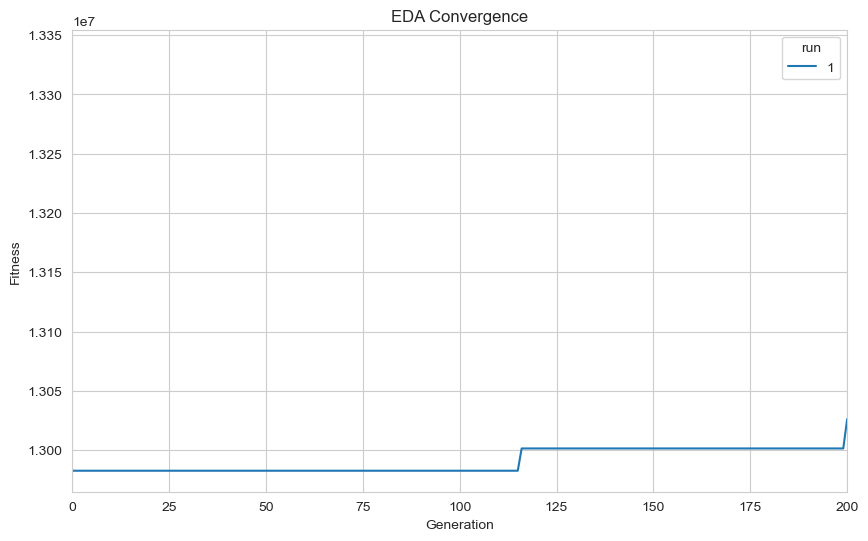

In [5]:
estimation_of_distribution_algorithm = eda.EDA(population_size=75, generations=500, profits=profits, weights=weights, capacity=capacity, items=len(solution))
population_fitness, fitness_results = estimation_of_distribution_algorithm.run()
fitness_results['run'] = 1

utils.plot_convergence(fitness_results, "EDA Convergence")

### Steady State Genetic Algorithm

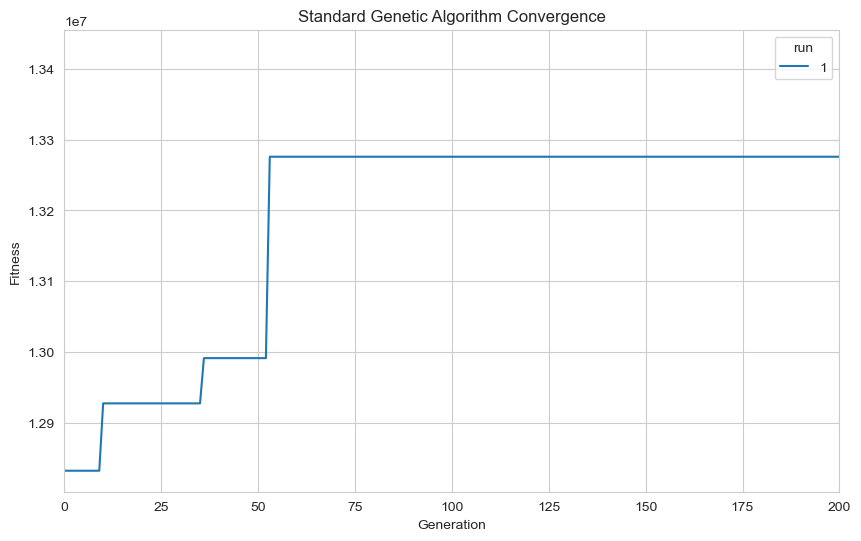

In [6]:
genetic_algorithm = ga.StandardGA(75, 500, profits, weights, capacity, mating_pool_size=10, mutation_rate=0.05, items=len(solution))
population_fitness, fitness_results = genetic_algorithm.run()
fitness_results['run'] = 1

utils.plot_convergence(fitness_results, "Standard Genetic Algorithm Convergence")

### CRISPR GA
The CRISPR GA identifies building blocks among the fittest solutions and inserts them according to their observed frequency, filtering by the most recent generations. In effect, this gives building blocks additional trials to mitigate potential disruption. This algorithm appears to have comparable performance to an EDA on the knapsack, although CRISPR GA may be more reliable across repeated runs. Both algorithms can acheive optimal or near optimal results.

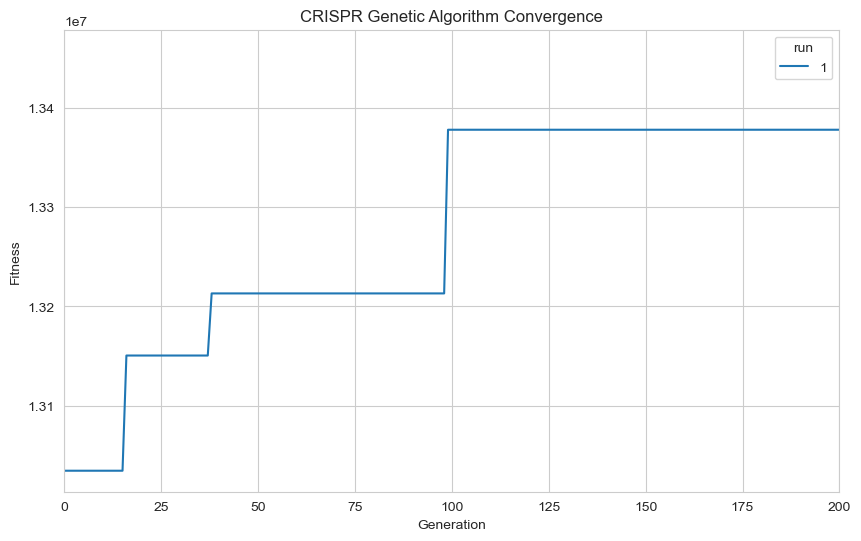

In [7]:
crispr_ga = cga.CrisprGA(75, 500, profits, weights, capacity, mating_pool_size=10, items=len(solution), sequence_length=4, threshold=0.5, dna_repair=True)
population_fitness_crispr, fitness_results_crispr = crispr_ga.run()
fitness_results_crispr['run'] = 1

utils.plot_convergence(fitness_results_crispr, "CRISPR Genetic Algorithm Convergence")

### Gene pool optimal mixing evolutionary algorithm
GOMEA performs optimal mixing of partial solutions by fixing crossover masks, and only accepting new genetic material if fitness is improved. No fitness based selection mechanism is used to select a parent for optimal mixing. Mutation is also not applied to maintain population diversity.
<br>
Initial results with static linkage models show fast convergence, but the final solution is not as good as EDA or CRISPR GA. This algorithm should achieve better performance if mutation, selection, and a more advanced linkage model are applied.

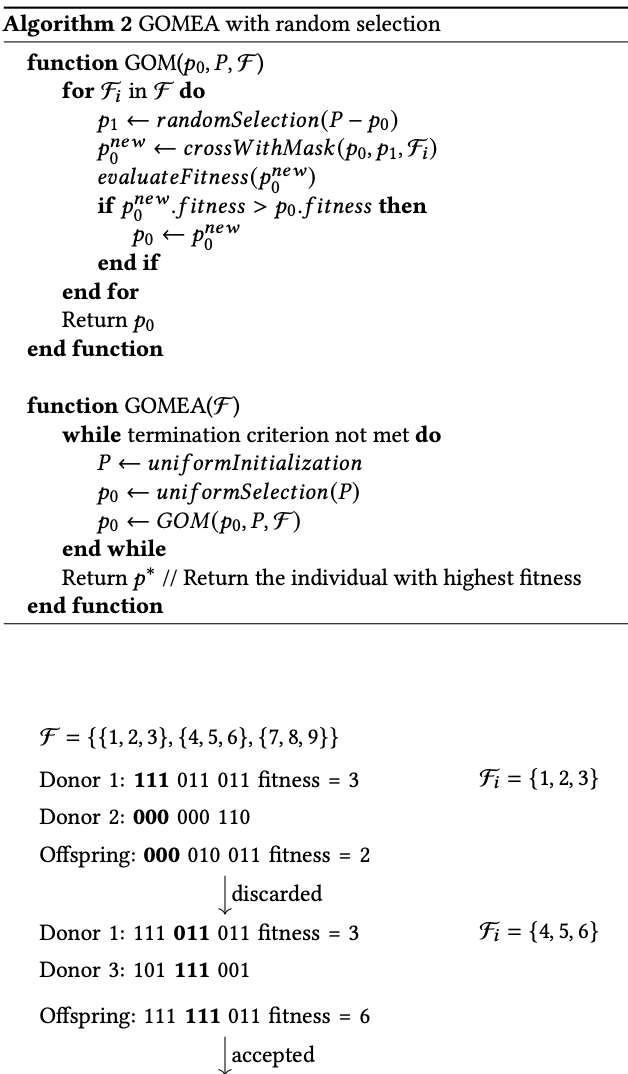

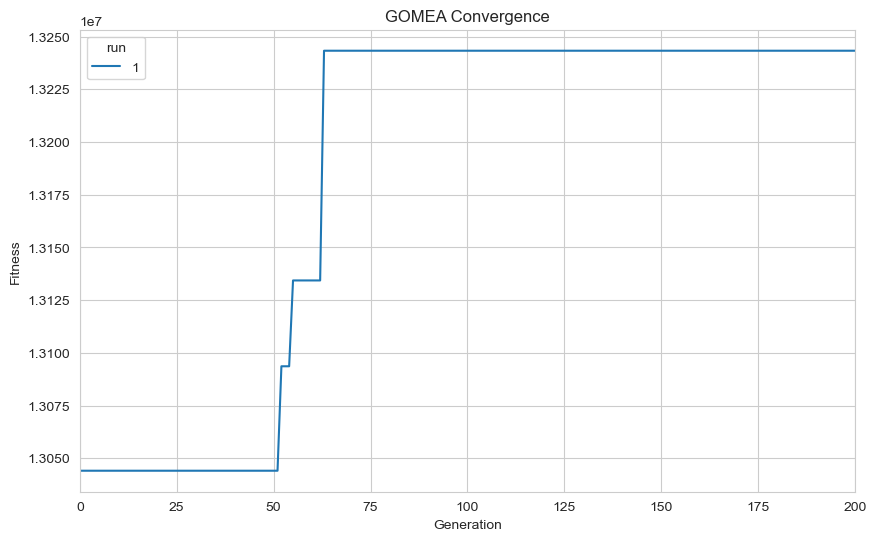

In [13]:
linkage_modal = linkage_model = [[i] for i in range(len(weights))]

gomea_algorithm = gomea.GOMEA(75, 500, profits, weights, capacity, mating_pool_size=10, items=len(solution), linkage_model=linkage_modal)

fitness_results_gomea = gomea_algorithm.run()
fitness_results_gomea['run'] = 1

utils.plot_convergence(fitness_results_gomea, "GOMEA Convergence")